## CIFAR-10 Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

import torch as torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import DataLoader,Subset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Transforms and download datasets 

In [3]:
transform = T.Compose([ T.ToTensor(),
                        T.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
                       ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
val_test  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
batchsize = 32

random_permutation = np.random.permutation(10000)

val_set = Subset(val_test, random_permutation[:5000])
test_set = Subset(val_test, random_permutation[5000:])

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=True, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batchsize, drop_last=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=len(test_set), drop_last=True, shuffle=True)

In [5]:
print(f'Length of train set: {len(trainset)}')
print(f'Length of validation set: {len(val_set)}')
print(f'Length of test set: {len(test_set)}')

Length of train set: 50000
Length of validation set: 5000
Length of test set: 5000


## Showing some Images

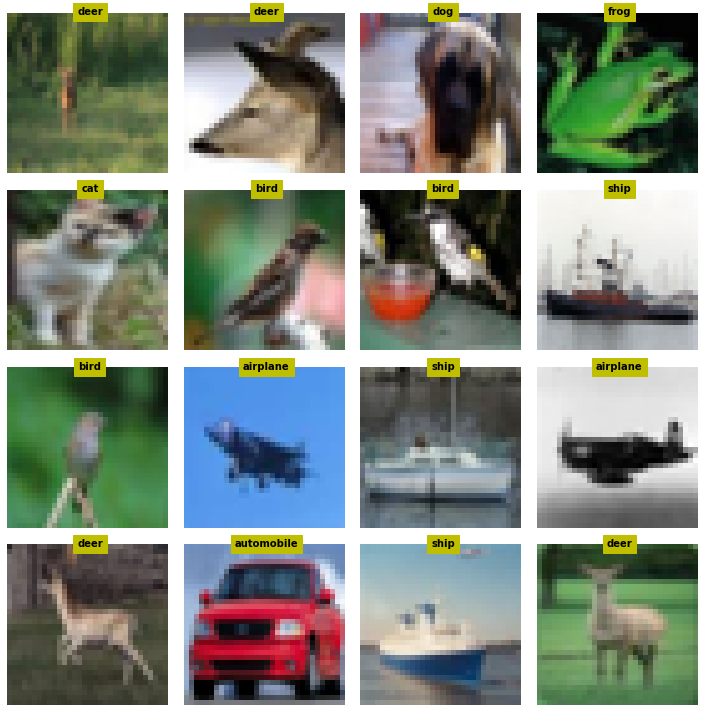

In [6]:
X, y = next(iter(train_loader))
fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 
  
  label = trainset.classes[y[i]]

  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

## Creating the CNN Model

In [7]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64,128,3)
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.fc1 = nn.Linear(128 * 2 * 2, 1000)
    self.fc2 = nn.Linear(1000, 10)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    

  def forward(self, x):
     x = self.batchnorm1(self.conv1(x))
     x = self.pool(F.relu((x)))
     x = self.batchnorm2(self.conv2(x))
     x = self.pool(F.relu(x))
     x = self.batchnorm3(self.conv3(x))
     x = self.pool(F.relu(x))
    # print(x.size())
     x = torch.flatten(x, 1) 
     x = F.dropout(x,p=0.2, training=self.training)
     x = F.relu(self.fc1(x))
     x = F.dropout(x,p=0.2, training=self.training)
     x = self.fc2(x)
     return x

In [8]:
model = CNN()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [9]:
model.parameters

<bound method Module.parameters of CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)>

In [10]:
epochs = 10
model.to(device)

train_loss = torch.zeros(epochs)
train_accuracy = torch.zeros(epochs)
val_loss = torch.zeros(epochs)
val_accuracy = torch.zeros(epochs)

for i in range(epochs):
  model.train()
  batch_loss = []
  batch_accuracy = []
  for X,y in train_loader:
    X = X.to(device)
    y = y.to(device)
           
    y_predict = model(X)
    losses = loss(y_predict,y)

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    batch_loss.append(losses.item())
    batch_accuracy.append(accuracy_score(y.cpu(), torch.argmax(y_predict.cpu(),axis=1)))
  train_loss[i] = np.mean(batch_loss)
  train_accuracy[i] = np.mean(batch_accuracy)
  print("epoch:", i , "train loss", losses.item())

  model.eval()
  batch_loss = []
  batch_accuracy =[]
  for X, y in val_loader:
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
      y_predict = model(X)
      losses = loss(y_predict,y)
      batch_loss.append(losses.item())
      batch_accuracy.append(accuracy_score(y.cpu(), torch.argmax(y_predict.cpu(),axis=1)))

  val_loss[i] = np.mean(batch_loss)
  val_accuracy[i] = np.mean(batch_accuracy)
  print("epoch:", i , "validation loss", losses.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0 train loss 1.0735214948654175
epoch: 0 validation loss 1.0488526821136475
epoch: 1 train loss 0.894156813621521
epoch: 1 validation loss 1.1292659044265747
epoch: 2 train loss 0.870646059513092
epoch: 2 validation loss 0.6904368996620178
epoch: 3 train loss 0.49593108892440796
epoch: 3 validation loss 1.018646478652954
epoch: 4 train loss 0.6848464608192444
epoch: 4 validation loss 0.5344215631484985
epoch: 5 train loss 0.5264019966125488
epoch: 5 validation loss 0.8145529627799988
epoch: 6 train loss 0.831282913684845
epoch: 6 validation loss 0.7543987035751343
epoch: 7 train loss 0.45743006467819214
epoch: 7 validation loss 0.9575852751731873
epoch: 8 train loss 0.3181540071964264
epoch: 8 validation loss 0.8868448734283447
epoch: 9 train loss 0.43510207533836365
epoch: 9 validation loss 0.5530734062194824


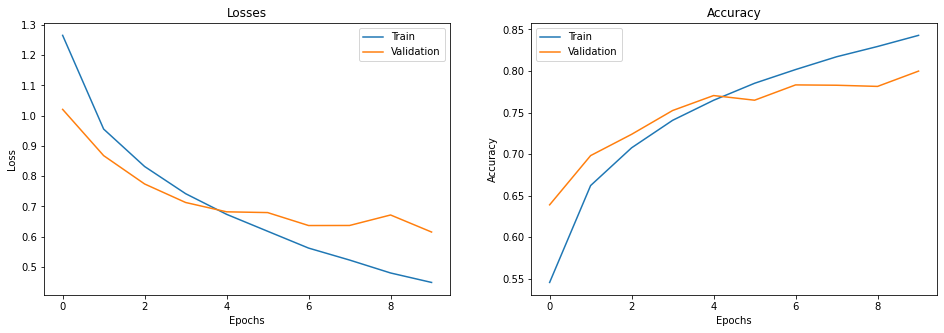

In [11]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(train_loss, label = 'Train')
ax[0].plot(val_loss, label = 'Validation')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(train_accuracy, label = 'Train')
ax[1].plot(val_accuracy, label = 'Validation')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()

## Testing the model

Test Accuracy = 0.7952


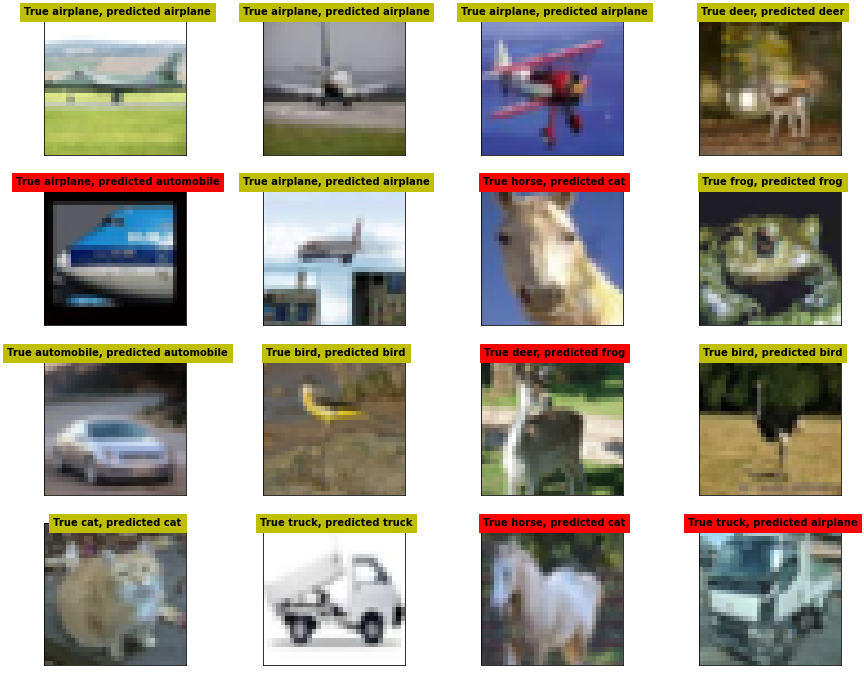

In [12]:
model.eval()
X,y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

with torch.no_grad():
  test_predict = model(X)
  test_loss = loss(test_predict, y)

test_losses = test_loss.item()
test_accuracy = accuracy_score(y.cpu(), torch.argmax(test_predict.cpu(),axis=1))
print(f'Test Accuracy = {test_accuracy}')

random_index = np.random.choice(len(y),size=21,replace=False)
ig,axs = plt.subplots(4,4,figsize=(15,12))

for i,ax in enumerate(axs.flatten()):

  true_category = trainset.classes[y[random_index[i]]]
  pred_category = trainset.classes[torch.argmax(test_predict[random_index[i],:])]
  
  ax.imshow((X[random_index[i]].cpu().numpy().transpose((1,2,0)))/2 + .5 )
  label_test = f'True {true_category}, predicted {pred_category}'
  background_test = 'y' if true_category==pred_category else 'r'
  ax.text(16,0,label_test,ha='center',fontweight='bold',color='k',backgroundcolor=background_test)
  ax.set_xticks([])
  ax.set_yticks([])  

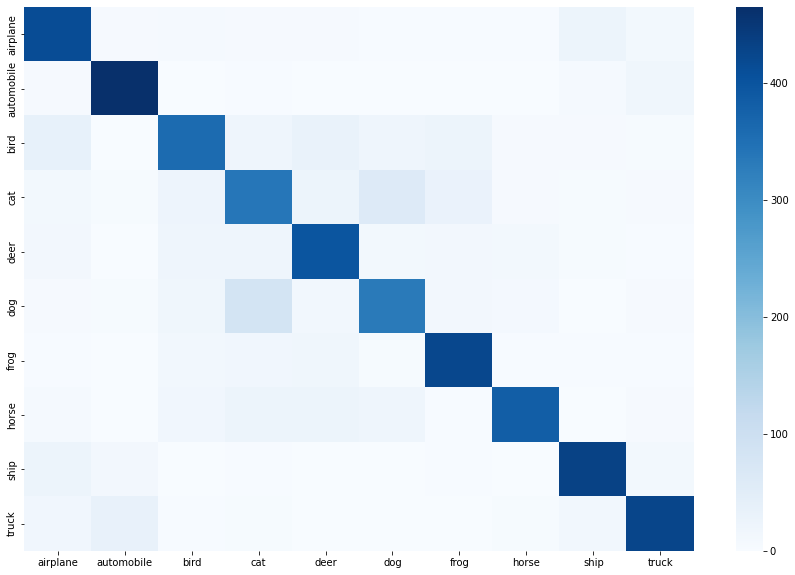

In [13]:
matrix = confusion_matrix(y.cpu(), torch.argmax(test_predict.cpu(),axis=1))
plt.figure(figsize=(15,10))
sns.heatmap(matrix, cmap='Blues', xticklabels=val_test.classes, yticklabels=val_test.classes)